In [2]:
import re
import json
import string
import random
import pandas as pd
from tqdm import tqdm
from collections import Counter
from itertools import combinations
import matplotlib.pyplot as plt

import spacy

# topic modeling 
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

import gensim

import pyLDAvis
import pyLDAvis.gensim

plt.style.use('seaborn-v0_8')

[nltk_data] Downloading package punkt to /home/devuser1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/devuser1/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/devuser1/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
path_to_data_raw = '/../../../../blobdata/raw/news.ndjson'
path_to_annotations = '../benchmark_data/annotations.json'
path_to_save_plots = 'plots/'

# Download data

In [4]:
df = pd.read_json(path_to_data_raw, lines=True, nrows=50000)

In [5]:
df.shape

(50000, 7)

In [6]:
df.head(5)

,tags+label_n,+abstract:en,+header:en,+url_n,published_at+timestamp,+body:en,+domain_n
0,"[Killing, General Crime, Eastern/Central Europ...",A Ukrainian officer interviewed by The New Yor...,"Zelensky is Pinocchio, officer tells The New Y...",[https://www.rt.com/russia/595692-zelensky-pin...,1712756741000,"The president's claim that just 31,000 Ukraini...",[rt.com]
1,"[LENS: Artificial Intelligence (AI), New Const...",Kevin Foster brings 25+ years of marketing exp...,SmartBear Names SVP of Growth Marketing to Sca...,[https://martechseries.com/sales-marketing/sma...,1712756619000,Kevin Foster brings 25+ years of marketing exp...,[martechseries.com]
2,"[LENS: Managed Services, New Construction, Dig...",New contract builds on existing partnership to...,Version 1 selected by National Highways as str...,[https://www.intelligentcio.com/eu/2024/04/10/...,1712756533000,New contract builds on existing partnership to...,[intelligentcio.com]
3,[United Kingdom of Great Britain and Northern ...,"(marketscreener.com) April 10, 2024 Accenture ...",Accenture : Acquires Unlimited to Further Bol...,[https://www.marketscreener.com/quote/stock/AC...,1712756473000,NaN,[marketscreener.com]
4,"[Organisational changes, Dairy Relevance Enhan...",RES appoints new CFO,RES appoints new CFO,[https://renews.biz/92447/res-appoints-new-cfo/],1712756422000,NaN,[renews.biz]


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   tags+label_n            50000 non-null  object
 1   +abstract:en            50000 non-null  object
 2   +header:en              50000 non-null  object
 3   +url_n                  50000 non-null  object
 4   published_at+timestamp  50000 non-null  int64 
 5   +body:en                16912 non-null  object
 6   +domain_n               50000 non-null  object
dtypes: int64(1), object(6)
memory usage: 2.7+ MB


# Data cleaning


In [8]:
def print_first_rows(df, column):

    for i in df.loc[0:10, column]:
        print(i, '\n-----------------\n')

In [9]:
data = df.copy()

In [10]:
data.rename({
    'tags+label_n':'tags', 
    '+abstract:en':'abstract', 
    '+header:en':'header', 
    '+url_n':'url', 
    'published_at+timestamp':'time',
    '+body:en':'body',
    '+domain_n':'domain'}, inplace=True, axis=1)

In [11]:
data['time'] = pd.to_datetime(data['time'], utc=True, unit='ms')
data['time'].apply(['min', 'max'])

min   2024-02-06 13:48:59+00:00
max   2024-04-10 13:45:41+00:00
Name: time, dtype: datetime64[ns, UTC]

In [12]:
print_first_rows(data, 'abstract')

A Ukrainian officer interviewed by The New Yorker has compared President Vladimir Zelensky to Pinocchio, for underreporting casualties Read Full Article at RT.com 
-----------------

Kevin Foster brings 25+ years of marketing experience with high-growth tech companies to SmartBear SmartBear, a leading provider of software development and visibility solutions, has welcomed Kevin Foster as Senior Vice President of Growth Marketing. Kevin comes to SmartBear from the startup Highway.ai and brings more than 25 years of experience in marketing for various high-growth tech […] 
-----------------

New contract builds on existing partnership to deliver a better experience for road users in England. Version 1, a leader in Digital Transformation, has announced it has been chosen by National Highways as a strategic long-term partner for managed services and collaboration across its infrastructure and platforms in a £47.5m contract award. The announcement builds […] 
-----------------

(marketscree

In [13]:
print_first_rows(data, 'header')

Zelensky is Pinocchio, officer tells The New Yorker 
-----------------

SmartBear Names SVP of Growth Marketing to Scale Global Reach of Software Development and AI Solutions 
-----------------

Version 1 selected by National Highways as strategic long-term partner in Digital Transformation 
-----------------

Accenture :  Acquires Unlimited to Further Bolster its CRM and Customer Relevance Capabilities 
-----------------

RES appoints new CFO 
-----------------

WATCHTOWER Firearms Names Graham Kohlmeyer Chief Operating Officer 
-----------------

Petra welcomes McCoy as senior sales lead 
-----------------

Weave Living, KKR partnership makes first property acquisition 
-----------------

L&T Metro Rail partners with Kitab Lovers Book Fair for literary extravaganza 
-----------------

Eric Trump Tells Fox & Friends RNC Needed to 'Restore Trust' By Hiring Wife Lara Trump 
-----------------

FLX Networks Partners with GK3 Capital to Provide Premier Digital Sales and Marketing for Asset

In [14]:
print_first_rows(data, 'body')

The president's claim that just 31,000 Ukrainian troops were killed in action obfuscates reality, according to magazine interview Ukrainian frontline casualties are far higher than what that country's leadership is willing to admit, according to The New Yorker. The American magazine published on Monday a deep dive into frontline realities of the Ukraine conflict, based on what reporter Luke Mogelson witnessed in January while he was embedded in one of the most motivated and well-equipped Ukrainian units. He mentioned hearing of an acquaintance of his, an infantry officer with whom he'd worked on another story a year ago. The news was that one of his former soldiers had been killed, to which Mogelson replied that the best Ukrainian men appeared to be dying these days. "Everyone dies here," the source responded. "The best, the worst. We remember the bright, strong personalities. Everyone else just fades into nothingness." Read more Zelensky pledges another counteroffensive READ MORE: Ukr

In [15]:
# lower abstract
data['abstract'] = data['abstract'].apply(lambda x: x.lower())

# remove digits
data['abstract']= data['abstract'].apply(lambda x: re.sub(r'\w*\d\w*','', x))

# remove punctuation
data['abstract'] = data['abstract'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

# remove extra spaces
data['abstract'] = data['abstract'].apply(lambda x: re.sub(r' +',' ',x))

In [16]:
pd.set_option('display.max_colwidth', 100)
data.iloc[240:241]

,tags,abstract,header,url,time,body,domain
240,"[TEMPLATE: GENERAL IRRELEVANT, Partnerships, Alliances & Joint Ventures (referee), Product Appro...",new partnership will unlock scaled access to the roblox audience for advertisers along with prem...,Roblox Taps PubMatic to Offer Programmatic Immersive Video Ads on Its Platform,[https://www.wallstreet-online.de/nachricht/17970170-roblox-taps-pubmatic-to-offer-programmatic-...,2024-04-10 13:05:00+00:00,NaN,[wallstreet-online.de]


# Data exploration

### Number of duplicates

In [17]:
# Find duplicates in 'tags+label_n' column
duplicates = data['abstract'].duplicated(keep=False)

# Count duplicates
duplicate_count = data[duplicates].shape[0]
duplicate_count

12458

### Number of characters, words

Text(0.5, 1.0, '# characters distribution in abstract')

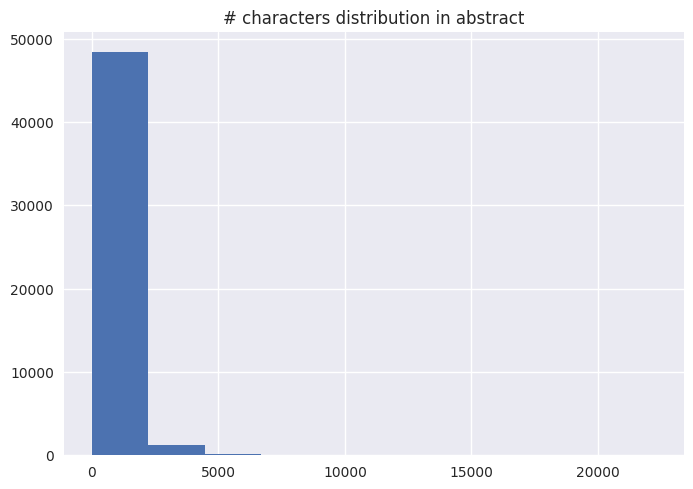

In [18]:
# number of characters
fig, ax = plt.subplots()

ax.hist(data['abstract'].str.len())
ax.set_title('# characters distribution in abstract')

Text(0.5, 1.0, '# characters distribution in abstract, restricted range')

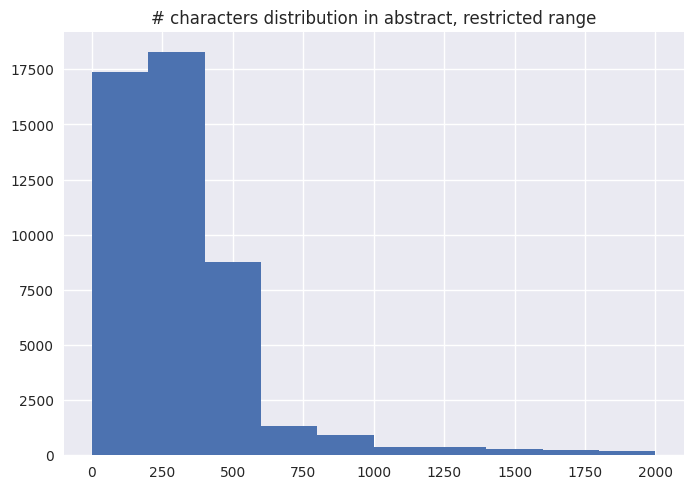

In [19]:
fig, ax = plt.subplots()

ax.hist(data['abstract'].str.len(), range=[0, 2000])
ax.set_title('# characters distribution in abstract, restricted range')

Text(0.5, 1.0, '# characters distribution in body')

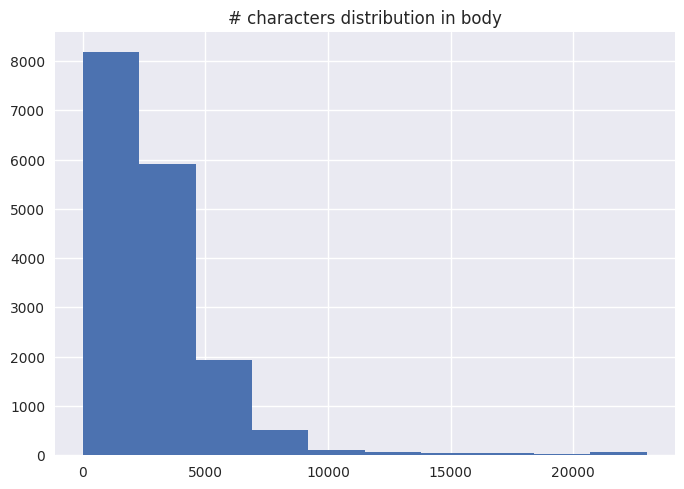

In [20]:
fig, ax = plt.subplots()

ax.hist(data['body'].str.len())
ax.set_title('# characters distribution in body')

Text(0.5, 1.0, '# words distribution in abstract')

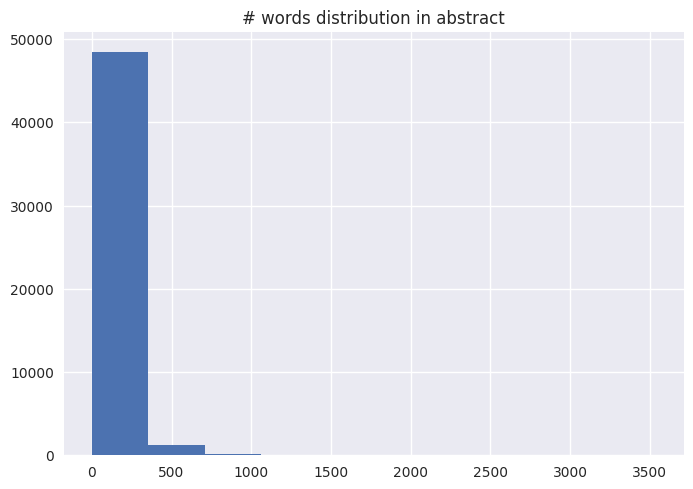

In [21]:
# number of words 
fig, ax = plt.subplots()

ax.hist(data['abstract'].str.split().map(lambda x: len(x)))
ax.set_title('# words distribution in abstract')

Text(0.5, 1.0, 'number of words in abstract distribution')

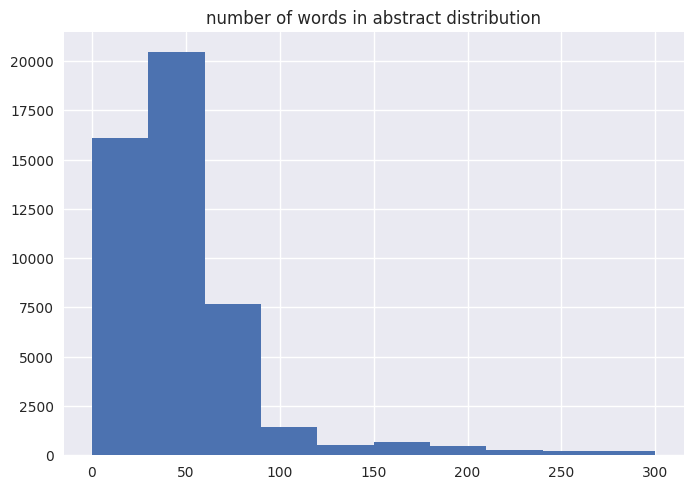

In [22]:
# number of words 
fig, ax = plt.subplots()

ax.hist(data['abstract'].str.split().map(lambda x: len(x)), range=[0, 300])
ax.set_title('number of words in abstract distribution')

Text(0.5, 1.0, '# words distribution in body')

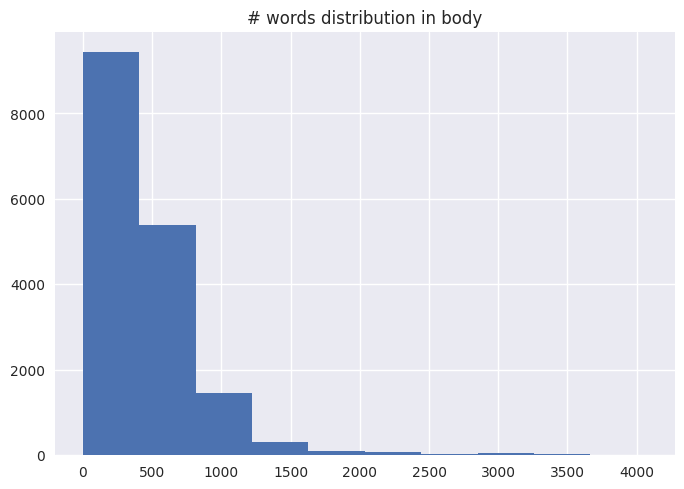

In [23]:
fig, ax = plt.subplots()

body_words = data['body'].str.split()

ax.hist(body_words[body_words.notnull()].map(lambda x: len(x)))
ax.set_title('# words distribution in body')

### Most frequent words

In [24]:
# remove stop words
# python -m spacy download en_core_web_lg

en = spacy.load('en_core_web_lg')
stopwords = en.Defaults.stop_words

def remove_stop_words(text):
    lst = []

    for token in text.split():
        if token not in stopwords:
            lst.append(token)

    return ' '.join(lst)


data['abstract_no_stop'] = data['abstract'].apply(lambda x: remove_stop_words(x))

In [25]:
data.head()

,tags,abstract,header,url,time,body,domain,abstract_no_stop
0,"[Killing, General Crime, Eastern/Central Europe, Vladimir, region in Russian Federation, general...",a ukrainian officer interviewed by the new yorker has compared president vladimir zelensky to pi...,"Zelensky is Pinocchio, officer tells The New Yorker",[https://www.rt.com/russia/595692-zelensky-pinocchio-ukrainian-casualties/?utm_source=rss&utm_me...,2024-04-10 13:45:41+00:00,"The president's claim that just 31,000 Ukrainian troops were killed in action obfuscates reality...",[rt.com],ukrainian officer interviewed new yorker compared president vladimir zelensky pinocchio underrep...
1,"[LENS: Artificial Intelligence (AI), New Construction, Marketing Trends, USA: within United Stat...",kevin foster brings years of marketing experience with highgrowth tech companies to smartbear sm...,SmartBear Names SVP of Growth Marketing to Scale Global Reach of Software Development and AI Sol...,[https://martechseries.com/sales-marketing/smartbear-names-svp-of-growth-marketing-to-scale-glob...,2024-04-10 13:43:39+00:00,Kevin Foster brings 25+ years of marketing experience with high-growth tech companies to SmartBe...,[martechseries.com],kevin foster brings years marketing experience highgrowth tech companies smartbear smartbear lea...
2,"[LENS: Managed Services, New Construction, Digital Transformation Innovations, Managed Services,...",new contract builds on existing partnership to deliver a better experience for road users in eng...,Version 1 selected by National Highways as strategic long-term partner in Digital Transformation,[https://www.intelligentcio.com/eu/2024/04/10/version-1-selected-by-national-highways-as-strateg...,2024-04-10 13:42:13+00:00,New contract builds on existing partnership to deliver a better experience for road users in Eng...,[intelligentcio.com],new contract builds existing partnership deliver better experience road users england version le...
3,"[United Kingdom of Great Britain and Northern Ireland, Parternships & Divestments, Mergers, Acqu...",marketscreenercom april accenture acquires unlimited to further bolster its crm and customer rel...,Accenture : Acquires Unlimited to Further Bolster its CRM and Customer Relevance Capabilities,[https://www.marketscreener.com/quote/stock/ACCENTURE-PLC-11521/news/Accenture-Acquires-Unlimite...,2024-04-10 13:41:13+00:00,NaN,[marketscreener.com],marketscreenercom april accenture acquires unlimited bolster crm customer relevance capabilities...
4,"[Organisational changes, Dairy Relevance Enhancer (loose), C-Level Changes (referee), C-Level Ch...",res appoints new cfo,RES appoints new CFO,[https://renews.biz/92447/res-appoints-new-cfo/],2024-04-10 13:40:22+00:00,NaN,[renews.biz],res appoints new cfo


In [26]:
# most frequent words in abstract

word_count = Counter(' '.join(data['abstract_no_stop']).split()).most_common(20)

Text(0.5, 1.0, 'most frequent words in abstract')

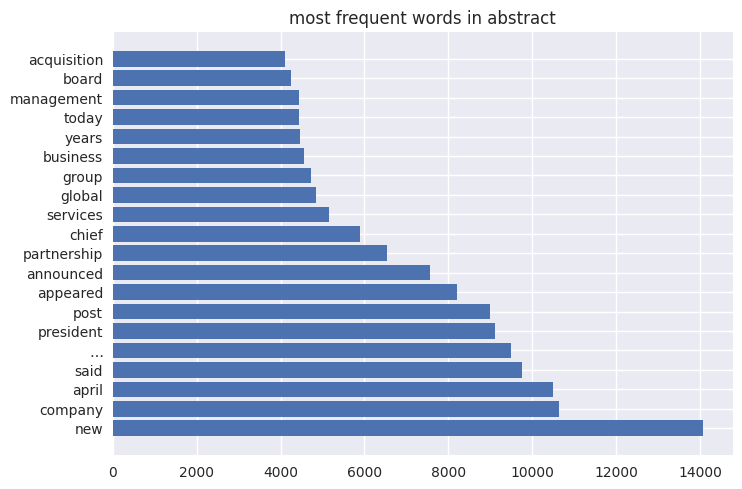

In [27]:
fig, ax = plt.subplots()

words = [word[0] for word in word_count]
values = [value[1] for value in word_count]

ax.barh(words, values)
ax.set_title('most frequent words in abstract')

### None per domain

In [28]:
# none per domain

data['Nan_body'] = data['body'].isna()
data['domain'] = data['domain'].astype('str')
df_grouped = data.groupby(by='domain').agg({'Nan_body':'sum'}).reset_index()
df_grouped.sort_values(by='Nan_body', ascending=False)[:10]

,domain,Nan_body
2607,['onenewspage.com'],2600
2205,['marketscreener.com'],1638
362,['benzinga.com'],1401
404,['biztoc.com'],933
1486,['globenewswire.com'],809
1739,['indiatimes.com'],770
2849,['prweb.com'],724
3912,['wallstreet-online.de'],671
4096,['yahoo.com'],602
3072,['sanews.gov.za'],602


### Topic modeling

1. Tokenize - text is converted into list of tokens
2. Remove stop words
3. Lemmatize - reduce the inflectional forms of each word into a common base or root
4. Convert to the bag of words

In [30]:
def preprecess_text(df):
    corpus = []
    lem = WordNetLemmatizer()

    for abstract in tqdm(df['abstract_no_stop']):

        # tokenize the abstract
        words = word_tokenize(abstract)

        # reduce the inflectional fors of the words
        words = [lem.lemmatize(word) for word in words if len(word) > 2]

        corpus.append(words)

    return corpus

In [32]:
corpus = preprecess_text(data)

# create bag of words
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in tqdm(corpus)]

# create LDA model
lda_model = gensim.models.LdaMulticore(
    bow_corpus, 
    num_topics=8,
    id2word=dic,
    passes=10,
    workers=2)

100%|██████████| 50000/50000 [00:01<00:00, 31153.19it/s]


In [34]:
lda_model.show_topic(topicid=0)

[('company', 0.026061293),
 ('share', 0.015800424),
 ('stock', 0.010001144),
 ('acquisition', 0.008606048),
 ('million', 0.007547417),
 ('investor', 0.006832999),
 ('april', 0.006114795),
 ('firm', 0.006051824),
 ('shareholder', 0.0059284526),
 ('inc', 0.0056066588)]

In [35]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.062157  0.161854       1        1  19.619476
1      0.052308 -0.052428       2        1  19.336359
2      0.149547 -0.162270       3        1  18.640123
5      0.091488  0.127929       4        1  12.984645
0      0.131239 -0.027985       5        1  10.485758
3     -0.330405 -0.200738       6        1   7.302239
6      0.121195 -0.050096       7        1   6.292335
4     -0.153215  0.203734       8        1   5.339066, topic_info=            Term          Freq         Total Category  logprob  loglift
17       company  14937.000000  14937.000000  Default  30.0000  30.0000
1249         act   4605.000000   4605.000000  Default  29.0000  29.0000
60       service   7736.000000   7736.000000  Default  28.0000  28.0000
13639  amendment   3496.000000   3496.000000  Default  27.0000  27.0000
371        share   4250.000000   4250.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
108         post    486.104075   9473.936294   Topic8  -5.4242  -0.0398
703       action    323.041527   1226.012426   Topic8  -5.8328   1.5964
55      national    396.279276   3861.667095   Topic8  -5.6285   0.6534
86      appeared    439.786466   8578.332471   Topic8  -5.5243  -0.0406
580        state    368.437844   5699.201823   Topic8  -5.7013   0.1913

[594 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4684      8  0.997965         aap
4976      1  0.998516    abortion
2053      2  0.002356  accelerate
2053      3  0.994103  accelerate
1323      2  0.000597     acquire
...     ...       ...         ...
37        4  0.212305        year
37        5  0.109817        year
37        6  0.009817        year
37        7  0.046728        year
37        8  0.006937        year

[1451 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 3, 6, 1, 4, 7, 5])

In [36]:
pyLDAvis.save_html(vis, path_to_save_plots + 'lda_vis.html')

# Visuals for text

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.hist([len(abstract.split()) for abstract in data['abstract']], range=[0, 300])
ax1.set_title('Number of Words in Abstract Distribution')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Frequency')
ax1.tick_params(axis='both', which='major')


words = [word[0] for word in word_count]
values = [word[1] for word in word_count]

ax2.barh(words, values)
ax2.set_title('Most Frequent Words in Abstract')
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Words')
ax2.tick_params(axis='both', which='major')

plt.tight_layout()
plt.savefig(path_to_save_plots + 'abstracts_analysis.png')

plt.show()

In [12]:

# transform from json to pd.DataFrame ner

def split_text_into_sentences(row):
    """Splits each instance into multiple sentences with corresponding entities."""

    sentences = sent_tokenize(row['text'])
    entities = row['entities']
    entity_spans = row['entity_spans']
    labels = row['labels']
    
    new_rows = []
    for sentence in sentences:

        sentence_start_index = row['text'].find(sentence)
        sentence_end_index = sentence_start_index + len(sentence)

        sentence_entities = []
        sentence_entity_spans = []
        sentence_labels = []
        
        # filter entities, entity_spans, and labels for the current sentence
        for entity, span, label in zip(entities, entity_spans, labels):
            if span[0] >= sentence_start_index and span[1] <= sentence_end_index:
                adjusted_span = (span[0] - sentence_start_index, span[1] - sentence_start_index)

                sentence_entities.append(entity)
                sentence_entity_spans.append(adjusted_span)
                sentence_labels.append(label)
        
        if len(sentence_entities) != 0:
            new_row = {
                'text': sentence,
                'entities': sentence_entities,
                'entity_spans': sentence_entity_spans,
                'labels': sentence_labels
            }
            
            new_rows.append(new_row)
    
    return pd.DataFrame(new_rows)

def transform_json_ner(path):
    """
    Transforms json into pd.DataFrame.
    Args:
        path : string that contains path to the json file
    """

    with open(path) as f:
        data = json.load(f)

    texts = []
    entities = []
    entity_spans = []
    labels = []

    for item in data:

        item_entities = []
        item_entity_spans = []
        item_labels = []

        text = item['data']['text']
        annotations = item['annotations'][0]['result']

        for annotation in annotations:
            if annotation['type'] == 'labels':

                entity_span = (annotation['value']['start'], annotation['value']['end'])
                entity = annotation['value']['text']
                label = annotation['value']['labels'][0]

                
                item_entities.append(entity)
                item_entity_spans.append(entity_span)
                item_labels.append(label)

        texts.append(text)
        entities.append(item_entities)
        entity_spans.append(item_entity_spans)
        labels.append(item_labels)


    df = pd.DataFrame({'text': texts, 'entities': entities, 'entity_spans': entity_spans, 'labels': labels})
    df = pd.concat([split_text_into_sentences(row) for _, row in df.iterrows()], ignore_index=True)

    return df

# transform from json to pd.DataFrame re

class NoSentenceError(Exception):
    pass

def get_sentence(text, span):
    """Returns sentence for the given span"""

    sentences = sent_tokenize(text)
    for sentence in sentences:
        start_idx = text.find(sentence)
        end_idx = start_idx + len(sentence)
        if span[0] >= start_idx and span[1] <= end_idx:
            return sentence, start_idx
    
    raise NoSentenceError("entities are not in one sentence")

def adjust_span(span, offset):
    """Adjusts span"""

    return (span[0] - offset, span[1] - offset)

def transform_json_re(path, additional_rows=100):
    """Transfomrs json file into dataframe with entity relations, adds also rows with no relation"""

    with open(path) as f:
        data = json.load(f)

    texts = []
    entity_pairs = []
    entity_spans_pairs = []
    relation_labels = []

    total_additional_rows = 0

    for item in data:
        item_entities = {}
        text = item['data']['text']
        annotations = item['annotations'][0]['result']

        related_pairs = set()
        for annotation in annotations:

            # first create list of entities in this text
            if annotation['type'] == 'labels':
                entity_span = (annotation['value']['start'], annotation['value']['end'])
                entity_text = annotation['value']['text']
                entity_id = annotation['id']
                entity_label = annotation['value']['labels'][0]
                item_entities[entity_id] = {'text': entity_text, 'span': entity_span, 'label': entity_label}

            # create entity pairs according to annotations
            elif annotation['type'] == 'relation':
                from_entity = item_entities[annotation['from_id']]
                to_entity = item_entities[annotation['to_id']]
                try:
                    label = annotation['labels'][0]
                except KeyError:
                    # if the labels is missing skip annotation
                    continue

                from_span = from_entity['span']
                to_span = to_entity['span']

                try: 
                    if from_span[0] < to_span[0]:
                        sentence, offset = get_sentence(text, (from_span[0], to_span[1]))
                    else:
                        sentence, offset = get_sentence(text, (to_span[0], from_span[1]))
                except NoSentenceError as e:
                    print(e)
                    continue

                # adjust span of the entities according to the sentence
                from_span_adjusted = adjust_span(from_span, offset)
                to_span_adjusted = adjust_span(to_span, offset)

                # add relation to the dataframe
                texts.append(sentence)
                entity_pairs.append((from_entity['text'], to_entity['text']))
                entity_spans_pairs.append((from_span_adjusted, to_span_adjusted))
                relation_labels.append(label)

                # list of entity pairs that are actually related
                related_pairs.add((from_entity['text'], to_entity['text']))

        # create all possible pairs of the entities in this text
        all_entities = list(item_entities.values())
        all_pairs = list(combinations(all_entities, 2))

        # entity pairs that does not have a relation
        non_related_pairs = [(e1, e2) for e1, e2 in all_pairs if (e1['text'], e2['text']) not in related_pairs]

        random.shuffle(non_related_pairs)
        for non_related_pair in non_related_pairs:
            if total_additional_rows >= additional_rows:
                break

            e1, e2 = non_related_pair
            from_span = e1['span']
            to_span = e2['span']

            try: 
                if from_span[0] < to_span[0]:
                    sentence, offset = get_sentence(text, (from_span[0], to_span[1]))
                else:
                    sentence, offset = get_sentence(text, (to_span[0], from_span[1]))
            except NoSentenceError as e:
                continue

            from_span_adjusted = adjust_span(from_span, offset)
            to_span_adjusted = adjust_span(to_span, offset)

            texts.append(sentence)
            entity_pairs.append((e1['text'], e2['text']))
            entity_spans_pairs.append((from_span_adjusted, to_span_adjusted))
            relation_labels.append('NIL')

            total_additional_rows += 1

    df = pd.DataFrame({'text': texts, 'entity_pairs': entity_pairs, 'entity_spans_pairs': entity_spans_pairs, 'label': relation_labels})
    return df




df_ner = transform_json_ner(path_to_annotations)
df_re = transform_json_re(path_to_annotations)

entities are not in one sentence
entities are not in one sentence
entities are not in one sentence
entities are not in one sentence
entities are not in one sentence
entities are not in one sentence
entities are not in one sentence
entities are not in one sentence
entities are not in one sentence


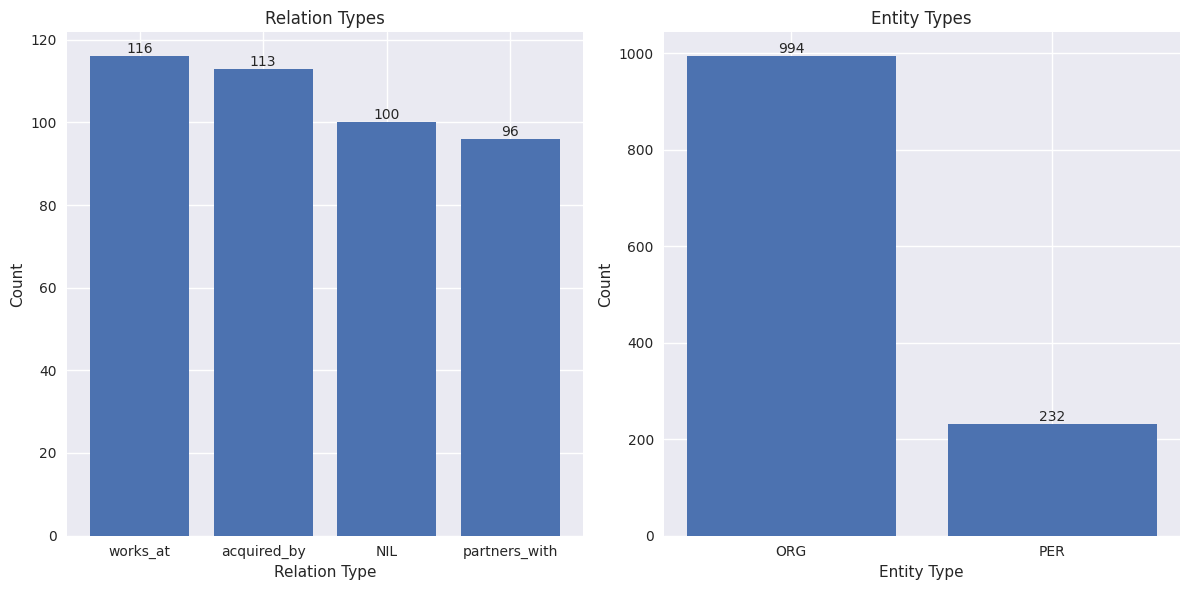

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Histogram for relation types
value_counts = df_re['label'].value_counts()
ax1.bar(value_counts.index, value_counts.values)

# Adding text annotations
for container in ax1.containers:
    ax1.bar_label(container, label_type='edge')

ax1.set_xlabel('Relation Type')
ax1.set_ylabel('Count')
ax1.set_title('Relation Types')
ax1.tick_params(axis='x', rotation=0) 

# Histogram for entity types
all_labels = [label for sublist in df_ner['labels'] for label in sublist]
value_counts = pd.Series(all_labels).value_counts()
ax2.bar(value_counts.index, value_counts.values)

for container in ax2.containers:
    ax2.bar_label(container, label_type='edge')

ax2.set_xlabel('Entity Type')
ax2.set_ylabel('Count')
ax2.set_title('Entity Types')
ax2.tick_params(axis='x', rotation=0) 

plt.tight_layout()
plt.savefig(path_to_save_plots + 'benchmark.png')

plt.show()